Performs Lasso Regression on Dummified data set to do feature selection on coefficients 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [2]:
data_train = pd.read_csv('RowFiltered_dummied_data_TRAIN.csv')
data_test = pd.read_csv('RowFiltered_dummied_data_TEST.csv')
data_train = data_train.drop('Lat_Long', axis=1)
data_test = data_test.drop('Lat_Long', axis=1)

In [3]:
# list(data_train.columns)

In [4]:
data_train.head()

,SalePrice,Dist_From_UoI,GrLivArea,1stFlrSF,2ndFlrSF,TotRmsAbvGrd,BedroomAbvGr,FullBath,HalfBath,MSSubClass_>1-story,...,WoodDeckBinary,HasPorch,FenceBinary,Fireplaces,NoCentralAir,SchD_S,Neighborhood Cluster Label_2,Neighborhood Cluster Label_3,Neighborhood Cluster Label_4,Neighborhood Cluster Label_5
0,179200,3.587525,1294,1294,0,6,3,2,0,0,...,1,1,1,0,0,0,0,0,0,0
1,115000,3.084359,1540,1040,500,7,4,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,110000,2.937397,892,892,0,5,3,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,131750,1.868841,960,960,0,4,2,1,0,0,...,1,1,0,0,0,0,0,0,0,0
4,190000,3.337009,1969,1161,808,8,3,2,1,1,...,0,1,0,1,0,0,0,0,0,0


In [5]:
#split y col 
data_testx=data_test.iloc[:,1:]
data_testy=data_test.iloc[:,0]
data_trainx=data_train.iloc[:,1:]
data_trainy=data_train.iloc[:,0]



In [6]:
#list(data_trainx.columns)

In [7]:
#standardize test and train
nonbinarycols=['Dist_From_UoI',
 'GrLivArea',
 '1stFlrSF',
 '2ndFlrSF',
 'TotRmsAbvGrd',
 'BedroomAbvGr',
 'FullBath',
 'HalfBath',
 
 'LotArea',

 'YearBuilt',
 'OverallQual',
 
 
 'RemodelYrsAftBuilt',
 
 'TotalBsmtSF',
 'BsmtUnfSF',
 
 'BsmtHalfBath',
 'BsmtFullBath',

 
 'GarageArea',
 'GarageCars',
 
 'Fireplaces'
 ]


In [8]:
scaler=StandardScaler()
scaler.fit(data_trainx[nonbinarycols])
data_trainx[nonbinarycols]=scaler.transform(data_trainx[nonbinarycols])
scaler.fit(data_testx[nonbinarycols])
data_testx[nonbinarycols]=scaler.transform(data_testx[nonbinarycols])

## CV Lasso regular data 

In [9]:
#CV LASSO FOR REG DATA
cvlasso=LassoCV( alphas=np.linspace(.0000001,20,1000), fit_intercept=True, normalize=False, cv=10, n_jobs=-1)
cvlasso.fit(data_trainx,data_trainy)

lasso=Lasso(alpha=cvlasso.alpha_, fit_intercept=True, normalize=False)

print(f'The selected alpha was {cvlasso.alpha_} which gave r^2 of ')
print(cross_val_score(lasso, data_trainx,data_trainy,  scoring='r2'))
print('Numer of iterations: ', cvlasso.n_iter_)
stdev = np.sqrt(sum((cvlasso.predict(data_trainx) - data_trainy)**2) / (len(data_trainy) - 2))
#prediction - 1.96*stdev, prediction + 1.96*stdev
#feel these are inflated bc alpha is trained on some of the later validating points

C:\Users\ryanb\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1310769481.4135742, tolerance: 615732670.0002332
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\ryanb\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 208451088217.00482, tolerance: 623182899.7937
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\ryanb\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209559789628.90735, tolerance: 620264375.2937981
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\ryanb\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: Co

The selected alpha was 11.011011055955954 which gave r^2 of 


C:\Users\ryanb\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2144760572.3728638, tolerance: 537012711.1193733
  model = cd_fast.enet_coordinate_descent(


[0.92351147 0.92737508 0.88076823 0.92046593 0.91921468]
Numer of iterations:  779


In [10]:
#actual test error 
cvlasso.score(data_testx,data_testy)

0.920412210254502

In [11]:
#find mse for predictions in the .9-1.1 times the predicted price range

def mseprediction(pred, allpredictions, data_trainy):
    try:
        return mean_squared_error(data_trainy[(allpredictions<=pred*1.1) & (allpredictions>=pred*.9)],allpredictions[(allpredictions<=pred*1.1) & (allpredictions>=pred*.9)])**.5
    except:
        try:
            return mean_squared_error(data_trainy[(allpredictions<=pred*1.2) & (allpredictions>=pred*.8)],allpredictions[(allpredictions<=pred*1.1) & (allpredictions>=pred*.9)])**.5
        except:
            return 0


In [12]:
#assuming constant variance of ys 

predictiondf=pd.DataFrame({'Prediction': cvlasso.predict(data_testx), 'Lower Bound 95%CI': cvlasso.predict(data_testx)- 1.96*stdev,'Upper Bound 95%CI':cvlasso.predict(data_testx)+ 1.96*stdev})
actualpredictions=cvlasso.predict(data_trainx)
# finding avrg mse for prediction in +-10% price range
avrgmseperpredict=predictiondf.Prediction.apply(lambda x: mseprediction(x, actualpredictions, data_trainy))


In [13]:
predictiondf=pd.DataFrame({'Prediction': cvlasso.predict(data_testx),'Lower Bound Avrg MSE':-avrgmseperpredict+ cvlasso.predict(data_testx),'Upper Bound Avrg MSE':avrgmseperpredict+ cvlasso.predict(data_testx),'Lower Bound 95%CI': cvlasso.predict(data_testx)- 1.96*stdev,'Upper Bound 95%CI':cvlasso.predict(data_testx)+ 1.96*stdev})
predictiondf




,Prediction,Lower Bound Avrg MSE,Upper Bound Avrg MSE,Lower Bound 95%CI,Upper Bound 95%CI
0,210182.644895,191638.293134,228726.996656,174169.377876,246195.911914
1,204150.508990,185450.950130,222850.067849,168137.241971,240163.776008
2,324531.907808,291841.361129,357222.454487,288518.640789,360545.174827
3,174375.405314,157606.520362,191144.290266,138362.138295,210388.672333
4,169892.969965,153749.603900,186036.336031,133879.702946,205906.236984
...,...,...,...,...,...
728,126400.522411,114110.677658,138690.367163,90387.255392,162413.789429
729,146874.070840,133117.274410,160630.867269,110860.803821,182887.337858
730,93148.488062,80747.779034,105549.197090,57135.221043,129161.755081
731,112263.096753,99938.289264,124587.904242,76249.829734,148276.363772


In [14]:
#get that df with prediction and ci for one instance
def makeaprediction(xvars,model,data_trainx,data_trainy):
    stdev=np.sqrt(sum((model.predict(data_trainx) - data_trainy)**2) / (len(data_trainy) - 2))
    actualpredictions=model.predict(data_trainx)
    avrgmseperpredict=mseprediction(model.predict(xvars), actualpredictions, data_trainy)
    return pd.DataFrame({'Prediction': model.predict(xvars),'Lower Bound Avrg MSE':-avrgmseperpredict+ model.predict(xvars),'Upper Bound Avrg MSE':avrgmseperpredict+ model.predict(xvars),'Lower Bound 95%CI': model.predict(xvars)- 1.96*stdev,'Upper Bound 95%CI':model.predict(xvars)+ 1.96*stdev})



In [15]:
reshapexinputs=pd.DataFrame([data_testx.loc[0,:]],columns=data_trainx.columns)
makeaprediction(reshapexinputs,cvlasso,data_trainx,data_trainy)

,Prediction,Lower Bound Avrg MSE,Upper Bound Avrg MSE,Lower Bound 95%CI,Upper Bound 95%CI
0,210182.644895,191638.293134,228726.996656,174169.377876,246195.911914


In [16]:
results=pd.DataFrame({'Attr':data_trainx.columns,'Coef':cvlasso.coef_})
results[results.Coef!=0].sort_values(by=['Coef'],key=abs)
Nonzerocoefs=results[results.Coef!=0].Attr
results[results.Coef!=0]

,Attr,Coef
0,Dist_From_UoI,-3245.448466
1,GrLivArea,10426.646159
2,1stFlrSF,11226.106502
3,2ndFlrSF,14933.178270
4,TotRmsAbvGrd,30.618927
...,...,...
82,SchD_S,8209.052964
83,Neighborhood Cluster Label_2,641.868205
84,Neighborhood Cluster Label_3,21916.747454
85,Neighborhood Cluster Label_4,5449.626407


In [17]:
lasso_coefs_df = results[results.Coef!=0]
lasso_coefs_df.sort_values(by='Coef', key=abs, ascending=False).iloc[0:40,:]

,Attr,Coef
39,ExterQual_Ex,40304.812130
35,Foundation_Wood,-36290.427842
45,KitchenQual_Ex,25992.771206
50,Functional_Maj,-24466.997471
84,Neighborhood Cluster Label_3,21916.747454
38,OverallCondBinary,-21317.012270
34,Foundation_Stone,20490.048757
56,BsmtQual_None,18752.263898
58,TotalBsmtSF,15946.320192
3,2ndFlrSF,14933.178270


In [18]:
lasso_coefs_df.sort_values(by='Coef', key=abs, ascending=False).iloc[40:,:]

,Attr,Coef
80,Fireplaces,4.383035e+03
40,ExterQual_Fa,4.255724e+03
66,BsmtQual_Fa,3.712962e+03
5,BedroomAbvGr,-3.631999e+03
43,HeatingQC_TA,-3.536990e+03
13,SlopedLot,3.497054e+03
72,GarageArea,3.328532e+03
52,FireplaceQu_Gd,-3.255475e+03
0,Dist_From_UoI,-3.245448e+03
75,GarageFinish_RFn,-3.230225e+03


In [19]:
# What did the Lasso drop?
set(data_trainx.columns) - set(data_trainx[Nonzerocoefs].columns)

{'BsmtCond_Fa', 'KitchenQual_Fa', 'NonStdElectrical'}

Our model only dropped 3 columns! clearly we need to do more sorting ourselves. I know there are more columns that should be dropped.

In [20]:
data_trainx[Nonzerocoefs].columns

Index(['Dist_From_UoI', 'GrLivArea', '1stFlrSF', '2ndFlrSF', 'TotRmsAbvGrd',
       'BedroomAbvGr', 'FullBath', 'HalfBath', 'MSSubClass_>1-story',
       'BldgType_Twnhs', 'BldgType_TwnhsE', 'LotArea', 'LotShape_IR',
       'SlopedLot', 'LotConfig_Corner', 'LotConfig_CulDSac',
       'Condition1_Artery', 'Condition1_Feedr', 'Condition1_Pos',
       'Condition1_RailRd', 'MasVnrArea', 'MasVnrType_BrkFace',
       'MasVnrType_StoneBrkcom', 'RoofStyle_Hip', 'RoofStyle_Other',
       'Exterior1st_AsbShng', 'Exterior1st_BrkFace', 'Exterior1st_HdbdOther',
       'Exterior1st_MetalSd', 'Exterior1st_Stc_CemBd_WdSdSh',
       'Foundation_BrkTil', 'Foundation_PConc', 'Foundation_Slab',
       'Foundation_Stone', 'Foundation_Wood', 'YearBuilt', 'OverallQual',
       'OverallCondBinary', 'ExterQual_Ex', 'ExterQual_Fa', 'ExterQual_Gd',
       'HeatingQC_Gd', 'HeatingQC_TA', 'HeatingQC_Fa', 'KitchenQual_Ex',
       'KitchenQual_Gd', 'RemodelYrsAftBuilt', 'Functional_Min',
       'Functional_Maj', 'Fi

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [22]:
vifs = []
names_cols = []
for i in range(len(data_trainx[Nonzerocoefs].columns)):
    v = round(vif(np.matrix(data_trainx[Nonzerocoefs]), i),2)
    names_cols.append(f'VIF {data_trainx[Nonzerocoefs].columns[i]}')
    vifs.append(v)
vif_df = pd.DataFrame([names_cols, vifs]).T
vif_df.columns=['Feature', 'VIF']

    

C:\Users\ryanb\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [23]:
vif_df.sort_values('VIF',ascending=False).iloc[0:40]

,Feature,VIF
54,VIF BsmtQual_None,inf
55,VIF BsmtCond_None,inf
67,VIF GarageType_None,inf
68,VIF GarageFinish_None,inf
1,VIF GrLivArea,111.82
3,VIF 2ndFlrSF,86.88
2,VIF 1stFlrSF,74.14
35,VIF YearBuilt,11.88
8,VIF MSSubClass_>1-story,9.13
56,VIF TotalBsmtSF,7.32


Really need to talk as a team about what to do, but I think these are candidates for dropping and re-running.
- Keep GarageCars.  Drop GarageFinish_none, GarageArea, GarageType_None
- Keep MSSubClass>1Story.  Drop 1stFlrSF and 2ndFlrSF
- Keep BsmtCond_None. Drop BsmtQual_None, maybe drop BsmtUnfSF

In [24]:
# csv of SalePrice lasso selected cols
data_trainx[Nonzerocoefs].to_csv(r'Lasso_Selected_Cols_TRAIN.csv', index=False)
data_testx[Nonzerocoefs].to_csv(r'Lasso_Selected_Cols_TEST.csv', index=False)

Text(0.5, 0, 'Actual')

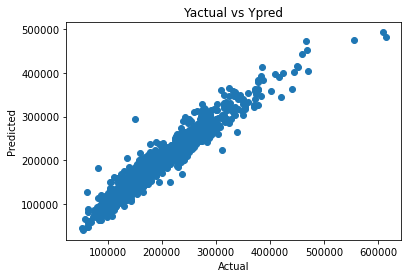

In [25]:
plt.scatter(data_trainy,cvlasso.predict(data_trainx) )
plt.title('Yactual vs Ypred')
plt.ylabel('Predicted')
plt.xlabel('Actual')

In [26]:
# Never used it, but want to in the future

#from sklearn.feature_selection import chi2
#chi2(data_train['TotRmsAbvGrd', ], data_train['GrLivArea'])

# ========================
# Redoing Lasso w/ Smaller dataset
# Fixing obvious bad columns
# ========================

After first initial run, adding YearBuilt to the drop list (seems like this info is captured in quality and materials) as well as FireplacQu_TA (this info should be in the # fireplaces col as a 'dropped to that coefficient')

Afte second time, dropping TotRmsAbvGrd, it appears to be highly multicollinear with 

In [27]:
data_train = pd.read_csv('RowFiltered_dummied_data_TRAIN.csv')
data_test = pd.read_csv('RowFiltered_dummied_data_TEST.csv')
data_train = data_train.drop(['Lat_Long', 'GarageFinish_None', 'GarageArea', 'GarageType_None', 
                             '1stFlrSF', '2ndFlrSF', 'BsmtQual_None', 'BsmtUnfSF', 'YearBuilt', 
                              'FireplaceQu_TA', 'TotRmsAbvGrd'], axis=1)
data_test = data_test.drop(['Lat_Long', 'GarageFinish_None', 'GarageArea', 'GarageType_None', 
                             '1stFlrSF', '2ndFlrSF', 'BsmtQual_None', 'BsmtUnfSF', 'YearBuilt', 
                            'FireplaceQu_TA', 'TotRmsAbvGrd'], axis=1)

In [28]:
# list(data_train.columns)

In [29]:
data_train.head()

,SalePrice,Dist_From_UoI,GrLivArea,BedroomAbvGr,FullBath,HalfBath,MSSubClass_>1-story,BldgType_Twnhs,BldgType_TwnhsE,LotArea,...,WoodDeckBinary,HasPorch,FenceBinary,Fireplaces,NoCentralAir,SchD_S,Neighborhood Cluster Label_2,Neighborhood Cluster Label_3,Neighborhood Cluster Label_4,Neighborhood Cluster Label_5
0,179200,3.587525,1294,3,2,0,0,0,0,7153,...,1,1,1,0,0,0,0,0,0,0
1,115000,3.084359,1540,4,1,0,1,0,0,7150,...,0,0,0,0,0,0,0,0,0,0
2,110000,2.937397,892,3,1,0,0,0,0,9477,...,0,0,1,0,0,0,0,0,0,0
3,131750,1.868841,960,2,1,0,0,0,0,6400,...,1,1,0,0,0,0,0,0,0,0
4,190000,3.337009,1969,3,2,1,1,0,0,11952,...,0,1,0,1,0,0,0,0,0,0


In [30]:
#split y col 
data_testx=data_test.iloc[:,1:]
data_testy=data_test.iloc[:,0]
data_trainx=data_train.iloc[:,1:]
data_trainy=data_train.iloc[:,0]



In [31]:
#list(data_trainx.columns)

In [32]:
#standardize test and train
nonbinarycols=['Dist_From_UoI',
 'GrLivArea',
# 'TotRmsAbvGrd',
 'BedroomAbvGr',
 'FullBath',
 'HalfBath',
 
 'LotArea',

# 'YearBuilt',
 'OverallQual',
 
 
 'RemodelYrsAftBuilt',
 
 'TotalBsmtSF',
 
 'BsmtHalfBath',
 'BsmtFullBath',

 
 'GarageCars',
 
 'Fireplaces'
 ]


In [33]:
scaler=StandardScaler()
scaler.fit(data_trainx[nonbinarycols])
data_trainx[nonbinarycols]=scaler.transform(data_trainx[nonbinarycols])
scaler.fit(data_testx[nonbinarycols])
data_testx[nonbinarycols]=scaler.transform(data_testx[nonbinarycols])

## CV Lasso regular data 

In [34]:
#CV LASSO FOR REG DATA
cvlasso=LassoCV( alphas=np.linspace(1,30,1000), fit_intercept=True, normalize=False, cv=10, n_jobs=-1)
cvlasso.fit(data_trainx,data_trainy)

lasso=Lasso(alpha=cvlasso.alpha_, fit_intercept=True, normalize=False)

print(f'The selected alpha was {cvlasso.alpha_} which gave r^2 of ')
print(cross_val_score(lasso, data_trainx,data_trainy,  scoring='r2'))
print('Numer of iterations: ', cvlasso.n_iter_)
stdev = np.sqrt(sum((cvlasso.predict(data_trainx) - data_trainy)**2) / (len(data_trainy) - 2))
#prediction - 1.96*stdev, prediction + 1.96*stdev
#feel these are inflated bc alpha is trained on some of the later validating points

The selected alpha was 20.623623623623626 which gave r^2 of 
[0.91737028 0.91775369 0.86473219 0.91681668 0.91106801]
Numer of iterations:  54


In [35]:
#actual test error 
cvlasso.score(data_testx,data_testy)

0.9100444149741426

In [36]:
#find mse for predictions in the .9-1.1 times the predicted price range

def mseprediction(pred, allpredictions, data_trainy):
    try:
        return mean_squared_error(data_trainy[(allpredictions<=pred*1.1) & (allpredictions>=pred*.9)],allpredictions[(allpredictions<=pred*1.1) & (allpredictions>=pred*.9)])**.5
    except:
        try:
            return mean_squared_error(data_trainy[(allpredictions<=pred*1.2) & (allpredictions>=pred*.8)],allpredictions[(allpredictions<=pred*1.1) & (allpredictions>=pred*.9)])**.5
        except:
            return 0


In [37]:
#assuming constant variance of ys 

predictiondf=pd.DataFrame({'Prediction': cvlasso.predict(data_testx), 'Lower Bound 95%CI': cvlasso.predict(data_testx)- 1.96*stdev,'Upper Bound 95%CI':cvlasso.predict(data_testx)+ 1.96*stdev})
actualpredictions=cvlasso.predict(data_trainx)
# finding avrg mse for prediction in +-10% price range
avrgmseperpredict=predictiondf.Prediction.apply(lambda x: mseprediction(x, actualpredictions, data_trainy))


In [38]:
predictiondf=pd.DataFrame({'Prediction': cvlasso.predict(data_testx),'Lower Bound Avrg MSE':-avrgmseperpredict+ cvlasso.predict(data_testx),'Upper Bound Avrg MSE':avrgmseperpredict+ cvlasso.predict(data_testx),'Lower Bound 95%CI': cvlasso.predict(data_testx)- 1.96*stdev,'Upper Bound 95%CI':cvlasso.predict(data_testx)+ 1.96*stdev})
predictiondf




,Prediction,Lower Bound Avrg MSE,Upper Bound Avrg MSE,Lower Bound 95%CI,Upper Bound 95%CI
0,211112.152171,191993.624192,230230.680151,173072.571996,249151.732346
1,200499.557481,181791.430610,219207.684352,162459.977306,238539.137656
2,314304.919633,280579.740693,348030.098573,276265.339458,352344.499808
3,177692.244883,160779.700223,194604.789542,139652.664708,215731.825057
4,169627.439075,153200.596312,186054.281838,131587.858900,207667.019250
...,...,...,...,...,...
728,129683.427923,117597.487449,141769.368397,91643.847748,167723.008098
729,146381.218317,131872.658827,160889.777807,108341.638142,184420.798492
730,84729.624627,71371.096288,98088.152967,46690.044452,122769.204802
731,113970.085822,99951.653331,127988.518314,75930.505647,152009.665997


In [39]:
#get that df with prediction and ci for one instance
def makeaprediction(xvars,model,data_trainx,data_trainy):
    stdev=np.sqrt(sum((model.predict(data_trainx) - data_trainy)**2) / (len(data_trainy) - 2))
    actualpredictions=model.predict(data_trainx)
    avrgmseperpredict=mseprediction(model.predict(xvars), actualpredictions, data_trainy)
    return pd.DataFrame({'Prediction': model.predict(xvars),'Lower Bound Avrg MSE':-avrgmseperpredict+ model.predict(xvars),'Upper Bound Avrg MSE':avrgmseperpredict+ model.predict(xvars),'Lower Bound 95%CI': model.predict(xvars)- 1.96*stdev,'Upper Bound 95%CI':model.predict(xvars)+ 1.96*stdev})



In [40]:
reshapexinputs=pd.DataFrame([data_testx.loc[0,:]],columns=data_trainx.columns)
makeaprediction(reshapexinputs,cvlasso,data_trainx,data_trainy)

,Prediction,Lower Bound Avrg MSE,Upper Bound Avrg MSE,Lower Bound 95%CI,Upper Bound 95%CI
0,211112.152171,191993.624192,230230.680151,173072.571996,249151.732346


In [41]:
results=pd.DataFrame({'Attr':data_trainx.columns,'Coef':cvlasso.coef_})
results[results.Coef!=0].sort_values(by=['Coef'],key=abs)
Nonzerocoefs=results[results.Coef!=0].Attr
results[results.Coef!=0]

,Attr,Coef
0,Dist_From_UoI,-1574.564291
1,GrLivArea,23962.700569
2,BedroomAbvGr,-3786.960751
3,FullBath,1150.468834
4,HalfBath,2877.884592
...,...,...
71,NoCentralAir,480.421955
72,SchD_S,5745.809666
74,Neighborhood Cluster Label_3,21974.001883
75,Neighborhood Cluster Label_4,4038.750465


In [42]:
lasso_coefs_df = results[results.Coef!=0]
lasso_coefs_df.sort_values(by='Coef', key=abs, ascending=False).iloc[0:40,:]

,Attr,Coef
35,ExterQual_Ex,44932.511235
41,KitchenQual_Ex,28054.941335
1,GrLivArea,23962.700569
32,Foundation_Wood,-22523.525391
74,Neighborhood Cluster Label_3,21974.001883
34,OverallCondBinary,-21639.350982
46,Functional_Maj,-21357.478345
57,BsmtQual_Ex,19984.290871
51,BsmtCond_None,17551.672956
23,Exterior1st_AsbShng,-14857.176979


In [43]:
lasso_coefs_df.sort_values(by='Coef', key=abs, ascending=False).iloc[40:,:]

,Attr,Coef
4,HalfBath,2877.884592
65,GarageFinish_RFn,-2627.756024
10,SlopedLot,2553.155068
70,Fireplaces,2551.927265
11,LotConfig_Corner,-2278.800694
29,Foundation_PConc,2246.133265
38,HeatingQC_Gd,-2243.853372
9,LotShape_IR,2051.969841
69,FenceBinary,1787.896082
5,MSSubClass_>1-story,-1776.509644


In [44]:
# What did the Lasso drop?
set(data_trainx.columns) - set(data_trainx[Nonzerocoefs].columns)

{'BsmtCond_Gd',
 'ExterQual_Fa',
 'Exterior1st_Stc_CemBd_WdSdSh',
 'FireplaceQu_Po',
 'Foundation_Slab',
 'MasVnrType_StoneBrkcom',
 'Neighborhood Cluster Label_2',
 'RemodelYrsAftBuilt'}

Our model droppd a few more columns than before, even though we had fewer columns to begin with. Seems like we are getting somewhere!

In [45]:
data_trainx[Nonzerocoefs].columns

Index(['Dist_From_UoI', 'GrLivArea', 'BedroomAbvGr', 'FullBath', 'HalfBath',
       'MSSubClass_>1-story', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'LotArea',
       'LotShape_IR', 'SlopedLot', 'LotConfig_Corner', 'LotConfig_CulDSac',
       'Condition1_Artery', 'Condition1_Feedr', 'Condition1_Pos',
       'Condition1_RailRd', 'NonStdElectrical', 'MasVnrArea',
       'MasVnrType_BrkFace', 'RoofStyle_Hip', 'RoofStyle_Other',
       'Exterior1st_AsbShng', 'Exterior1st_BrkFace', 'Exterior1st_HdbdOther',
       'Exterior1st_MetalSd', 'Foundation_BrkTil', 'Foundation_PConc',
       'Foundation_Stone', 'Foundation_Wood', 'OverallQual',
       'OverallCondBinary', 'ExterQual_Ex', 'ExterQual_Gd', 'HeatingQC_Gd',
       'HeatingQC_TA', 'HeatingQC_Fa', 'KitchenQual_Ex', 'KitchenQual_Gd',
       'KitchenQual_Fa', 'Functional_Min', 'Functional_Maj', 'FireplaceQu_Ex',
       'FireplaceQu_Gd', 'FireplaceQu_Fa', 'BsmtCond_None', 'TotalBsmtSF',
       'BsmtFinGdLvng', 'BsmtHalfBath', 'BsmtFullBath', 'Bsmt

In [46]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [47]:
vifs = []
names_cols = []
for i in range(len(data_trainx[Nonzerocoefs].columns)):
    v = round(vif(np.matrix(data_trainx[Nonzerocoefs]), i),2)
    names_cols.append(f'VIF {data_trainx[Nonzerocoefs].columns[i]}')
    vifs.append(v)
vif_df = pd.DataFrame([names_cols, vifs]).T
vif_df.columns=['Feature', 'VIF']

    

In [48]:
vif_df.sort_values('VIF',ascending=False).iloc[0:40]

,Feature,VIF
1,VIF GrLivArea,6.39
5,VIF MSSubClass_>1-story,5.74
27,VIF Foundation_PConc,4.95
52,VIF BsmtQual_Gd,4.84
61,VIF HasPorch,4.32
33,VIF ExterQual_Gd,4.27
46,VIF TotalBsmtSF,3.82
30,VIF OverallQual,3.74
38,VIF KitchenQual_Gd,3.52
18,VIF MasVnrArea,2.99


Really need to talk as a team about what to do, but I think these are candidates for dropping and re-running.
- Keep GarageCars.  Drop GarageFinish_none, GarageArea, GarageType_None
- Keep MSSubClass>1Story.  Drop 1stFlrSF and 2ndFlrSF
- Keep BsmtCond_None. Drop BsmtQual_None, maybe drop BsmtUnfSF

In [49]:
# csv of SalePrice lasso selected cols
#data_trainx[Nonzerocoefs].to_csv(r'Lasso_Selected_Cols_TRAIN.csv', index=False)
#data_testx[Nonzerocoefs].to_csv(r'Lasso_Selected_Cols_TEST.csv', index=False)

Text(0.5, 0, 'Actual')

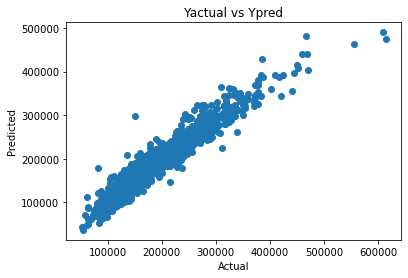

In [50]:
plt.scatter(data_trainy,cvlasso.predict(data_trainx) )
plt.title('Yactual vs Ypred')
plt.ylabel('Predicted')
plt.xlabel('Actual')

## Create MLR for interpretation of coefficients.
Need to make the model, then check the test-R^2 and the VIFs.

In [51]:
# Need to create the datasts again with no scaling
data_train = pd.read_csv('RowFiltered_dummied_data_TRAIN.csv')
data_test = pd.read_csv('RowFiltered_dummied_data_TEST.csv')
data_train = data_train.drop('Lat_Long', axis=1)
data_test = data_test.drop('Lat_Long', axis=1)

data_testx=data_test.iloc[:,1:]
data_testy=data_test.iloc[:,0]
data_trainx=data_train.iloc[:,1:]
data_trainy=data_train.iloc[:,0]

In [52]:
ols = LinearRegression()

In [58]:
## THIS IS THE SPOT FOR INTERPRETABLE COEFICIENTS FOR PRESENTATION
ols.fit(data_trainx[Nonzerocoefs], data_trainy)
print('Train score: ', ols.score(data_trainx[Nonzerocoefs], data_trainy))
print('Test score: ', ols.score(data_testx[Nonzerocoefs], data_testy))
coef_vals = pd.DataFrame({'Feature': data_trainx[Nonzerocoefs].columns, 'Coefficient': ols.coef_ })
coef_vals.sort_values(by='Coefficient', key=abs, ascending=False)[0:40]

Train score:  0.9225982387640418
Test score:  0.9103453626129846


,Feature,Coefficient
32,ExterQual_Ex,46039.058881
29,Foundation_Wood,-38765.671797
37,KitchenQual_Ex,28112.353933
41,Functional_Maj,-23330.918587
66,Neighborhood Cluster Label_3,22872.119403
31,OverallCondBinary,-22264.065878
51,BsmtQual_Ex,20569.522547
45,BsmtCond_None,19214.315615
22,Exterior1st_AsbShng,-17367.022993
28,Foundation_Stone,16548.943371


In [59]:
coef_vals.sort_values(by='Coefficient', key=abs, ascending=False)[40:]

,Feature,Coefficient
58,GarageFinish_RFn,-2948.440958
10,SlopedLot,2900.970192
39,KitchenQual_Fa,-2668.465652
42,FireplaceQu_Ex,-2527.085017
34,HeatingQC_Gd,-2521.073594
11,LotConfig_Corner,-2507.142965
3,FullBath,2327.231564
9,LotShape_IR,2173.771239
0,Dist_From_UoI,-2130.413522
62,FenceBinary,2065.342939


In [54]:
vifs = []
names_cols = []
for i in range(len(data_trainx[Nonzerocoefs].columns)):
    v = round(vif(np.matrix(data_trainx[Nonzerocoefs]), i),2)
    names_cols.append(f'VIF {data_trainx[Nonzerocoefs].columns[i]}')
    vifs.append(v)
vif_df = pd.DataFrame([names_cols, vifs]).T
vif_df.columns=['Feature', 'VIF']


In [55]:
vif_df.sort_values('VIF',ascending=False).head(30)

,Feature,VIF
1,VIF GrLivArea,77.16
30,VIF OverallQual,58.91
46,VIF TotalBsmtSF,30.01
2,VIF BedroomAbvGr,29.0
3,VIF FullBath,27.24
0,VIF Dist_From_UoI,23.91
56,VIF GarageCars,16.65
8,VIF LotArea,14.35
5,VIF MSSubClass_>1-story,6.59
27,VIF Foundation_PConc,5.09


In [56]:
stepwise_features = pd.read_csv('stepwise_R_coefs.csv', header=0, names=['Feature', 'R_Coefficient'])
stepwise_features

,Feature,R_Coefficient
0,(Intercept),-880307.299119
1,Exterior1st_AsbShng,-13422.311734
2,Foundation_Wood,-42227.758113
3,GarageFinish_RFn,-3830.781755
4,BsmtQual_None,14860.804501
5,Dist_From_UoI,-2308.939336
6,Exterior1st_HdbdOther,-5212.607895
7,BsmtFinGdLvng,5373.673204
8,Exterior1st_BrkFace,11974.503234
9,SchD_S,7226.063397


In [57]:
stepwise_compare = pd.merge(stepwise_features, coef_vals, how='left', on='Feature')
stepwise_compare.columns=['Feature', 'R_Coefficient', 'Python_MLR_Coefficient']
stepwise_compare['Diff_Ratio'] = abs((stepwise_compare['Python_MLR_Coefficient'] - stepwise_compare['R_Coefficient']) /
                                  stepwise_compare['R_Coefficient'])
stepwise_compare

,Feature,R_Coefficient,Python_MLR_Coefficient,Diff_Ratio
0,(Intercept),-880307.299119,NaN,NaN
1,Exterior1st_AsbShng,-13422.311734,-17367.022993,0.293892
2,Foundation_Wood,-42227.758113,-38765.671797,0.081986
3,GarageFinish_RFn,-3830.781755,-2948.440958,0.230329
4,BsmtQual_None,14860.804501,NaN,NaN
5,Dist_From_UoI,-2308.939336,-2130.413522,0.077319
6,Exterior1st_HdbdOther,-5212.607895,-3092.191166,0.406786
7,BsmtFinGdLvng,5373.673204,8136.400403,0.514123
8,Exterior1st_BrkFace,11974.503234,9523.861634,0.204655
9,SchD_S,7226.063397,6575.237974,0.090066


In [ ]:
## Note: I kind of want to go up to the model I am using for Lasso (or rather, the datasets) 
# and run it in the statsmodel package for regularized linear regression to get all the details on it.

# Maybe run the R stepwise features in an MLR in python statsmodel, to get the details to put into our app.

# ==================================
# This is the end of the important work I did
# ==================================

## Do it again on Log(SalePrice)

In [43]:
# create copy of train/test 
log_data_train = data_train.copy()
log_data_test = data_test.copy()

In [44]:
# log SalePrice and drop original column in test and train

log_data_train['log_SalePrice'] = np.log(log_data_train['SalePrice'])
log_data_train = log_data_train.drop(['SalePrice'], axis=1)
log_first_column = log_data_train.pop('log_SalePrice')
log_data_train.insert(0, 'log_SalePrice', log_first_column)

log_data_test['log_SalePrice'] = np.log(log_data_test['SalePrice'])
log_data_test = log_data_test.drop(['SalePrice'], axis=1)
log_first_columnt = log_data_test.pop('log_SalePrice')
log_data_test.insert(0, 'log_SalePrice', log_first_columnt)

In [45]:
log_data_testx=data_testx.copy()
log_data_testy=log_data_test.iloc[:,0]
log_data_trainx=data_trainx.copy()
log_data_trainy=log_data_train.iloc[:,0]

In [46]:
scaler.fit(log_data_trainx[nonbinarycols])
log_data_trainx[nonbinarycols]=scaler.transform(log_data_trainx[nonbinarycols])
scaler.fit(log_data_testx[nonbinarycols])
log_data_testx[nonbinarycols]=scaler.transform(log_data_testx[nonbinarycols])

In [47]:
#CV LASSO FOR LOG DATA
cvlasso=LassoCV( alphas=np.linspace(1e-7, 1e-4,1000), fit_intercept=True, normalize=False, cv=10, n_jobs=-1, max_iter=5000)
cvlasso.fit(log_data_trainx,log_data_trainy)

lasso=Lasso(alpha=cvlasso.alpha_, fit_intercept=True, normalize=False)
print(f'The selected alpha was {cvlasso.alpha_} which gave r^2 of ')
print(cross_val_score(lasso, log_data_trainx,log_data_trainy,  scoring='r2'))
print('Numer of iterations: ', cvlasso.n_iter_)
stdev = np.sqrt(sum((cvlasso.predict(log_data_trainx) - log_data_trainy)**2) / (len(log_data_trainy) - 2))
#prediction - 1.96*stdev, prediction + 1.96*stdev
#feel these are inflated bc alpha is trained on some of the later validating points

The selected alpha was 8.980000000000001e-05 which gave r^2 of 
[0.91750638 0.94113007 0.89412261 0.93429095 0.91941133]
Numer of iterations:  491


In [48]:
#actual test error 
cvlasso.score(log_data_testx,log_data_testy)

0.9253863882698996

In [49]:
results=pd.DataFrame({'Attr':log_data_trainx.columns,'Coef':cvlasso.coef_})
results[results.Coef!=0].sort_values(by=['Coef'],key=abs)
Nonzerocoefs=results[results.Coef!=0].Attr
results[results.Coef!=0]

,Attr,Coef
0,Dist_From_UoI,-0.020402
1,GrLivArea,0.060579
2,1stFlrSF,0.050177
3,2ndFlrSF,0.063828
4,TotRmsAbvGrd,-0.001870
...,...,...
82,SchD_S,0.024038
83,Neighborhood Cluster Label_2,0.036851
84,Neighborhood Cluster Label_3,0.010521
85,Neighborhood Cluster Label_4,0.058891


In [50]:
# csv of SalePrice log_lasso selected cols
log_data_trainx[Nonzerocoefs].to_csv(r'log_Lasso_Selected_Cols_TRAIN.csv', index=False)
log_data_testx[Nonzerocoefs].to_csv(r'log_Lasso_Selected_Cols_TEST.csv', index=False)

Text(0.5, 0, 'Actual')

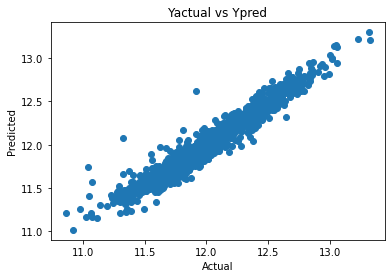

In [51]:
plt.scatter(log_data_trainy,cvlasso.predict(log_data_trainx) )

plt.title('Yactual vs Ypred')
plt.ylabel('Predicted')
plt.xlabel('Actual')

In [52]:
stdev = np.sqrt(sum((cvlasso.predict(log_data_trainx) - log_data_trainy)**2) / (len(log_data_trainy) - 2))
predictiondf=pd.DataFrame({'Prediction': cvlasso.predict(log_data_testx), 'Lower Bound 95%CI': cvlasso.predict(log_data_testx)- 1.96*stdev,'Upper Bound 95%CI':cvlasso.predict(log_data_testx)+ 1.96*stdev})

actualpredictions=cvlasso.predict(log_data_trainx)
# finding avrg mse for prediction in +-10% price range
avrgmseperpredict=predictiondf.Prediction.apply(lambda x: mseprediction(x, actualpredictions, log_data_trainy))



In [53]:
predictiondf=pd.DataFrame({'Prediction': cvlasso.predict(log_data_testx),'Lower Bound Avrg MSE':-avrgmseperpredict+ cvlasso.predict(log_data_testx),'Upper Bound Avrg MSE':avrgmseperpredict+ cvlasso.predict(log_data_testx),'Lower Bound 95%CI': cvlasso.predict(log_data_testx)- 1.96*stdev,'Upper Bound 95%CI':cvlasso.predict(log_data_testx)+ 1.96*stdev})

predictiondf


,Prediction,Lower Bound Avrg MSE,Upper Bound Avrg MSE,Lower Bound 95%CI,Upper Bound 95%CI
0,12.273121,12.181096,12.365146,12.092612,12.453630
1,12.144938,12.052906,12.236971,11.964430,12.325447
2,12.753539,12.663395,12.843684,12.573031,12.934048
3,12.080871,11.988809,12.172933,11.900362,12.261380
4,12.027352,11.935289,12.119414,11.846843,12.207860
...,...,...,...,...,...
728,11.800908,11.708740,11.893075,11.620399,11.981416
729,11.874117,11.782038,11.966196,11.693608,12.054626
730,11.493378,11.400792,11.585963,11.312869,11.673886
731,11.608946,11.516633,11.701259,11.428437,11.789455


# ===============================================
# I have not done anything below here
# ===============================================

## Lasso on Rs selected cols

In [54]:
rcols=["MasVnrType_BrkFace" ,  "Foundation_Stone" ,    "Exterior1st_AsbShng" , "LotArea"             
 , "Fireplaces"    ,       "HeatingQC_TA"     ,    "Exterior1st_BrkFace",  "Foundation_Wood"     
 , "Condition1_Artery" ,   "BsmtFinGdLvng"    ,    "Functional_Min" ,      "Neighborhood_NoRidge"
,"ExterQual_Gd"     ,    "BsmtExposure"       ,  "KitchenQual_Ex"  ,     "BsmtQual_Ex"         
,"Functional_Maj"    ,   "OverallCondBinary"  ,  "OverallQual"  ,        "ExterQual_Ex"        
,"TotalBsmtSF"   ,       "BsmtUnfSF"         ,   "GrLivArea"      ,      "LndAc_S" ]
data_trainxsubsetR=data_trainx[rcols]
data_testxsubsetR=data_testx[rcols]
lasso.set_params(alpha=0)
lasso.fit(data_trainxsubsetR, data_trainy) 
(lasso.score(data_trainxsubsetR, data_trainy))
(lasso.score(data_testxsubsetR, data_testy))

KeyError: "['Neighborhood_NoRidge', 'LndAc_S'] not in index"

In [ ]:
stdev = np.sqrt(sum((lasso.predict(data_trainxsubsetR) - data_trainy)**2) / (len(data_trainy) - 2))
predictiondf=pd.DataFrame({'Prediction': lasso.predict(data_testxsubsetR), 'Lower Bound 95%CI': lasso.predict(data_testxsubsetR)- 1.96*stdev,'Upper Bound 95%CI':lasso.predict(data_testxsubsetR)+ 1.96*stdev})

actualpredictions=lasso.predict(data_trainxsubsetR)
# finding avrg mse for prediction in +-10% price range
avrgmseperpredict=predictiondf.Prediction.apply(lambda x: mseprediction(x, actualpredictions, data_trainy))

predictiondf=pd.DataFrame({'Prediction': lasso.predict(data_testxsubsetR),'Lower Bound Avrg MSE':-avrgmseperpredict+ lasso.predict(data_testxsubsetR),'Upper Bound Avrg MSE':avrgmseperpredict+ lasso.predict(data_testxsubsetR),'Lower Bound 95%CI': lasso.predict(data_testxsubsetR)- 1.96*stdev,'Upper Bound 95%CI':lasso.predict(data_testxsubsetR)+ 1.96*stdev})

predictiondf




In [ ]:

# csv of R's ~23 cols
data_trainxsubsetR.to_csv(r'Stepwise_Selected_Cols_R_TRAIN.csv', index=False)
data_testxsubsetR.to_csv(r'Stepwise_Selected_Cols_R_TEST.csv', index=False)
